In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

In [2]:
src = "/home/andres/repos/rat-mapping-paper/reports/L_CIRC/inference.pkl"

with open(src, "rb") as f:
    df, encoder_dict, model, posterior_samples, = pickle.load(f)


prediction_df = model.make_prediction_dataset(df=df, min_intensity=0., max_intensity=500.)
posterior_predictive = model.predict(
    df=prediction_df, posterior_samples=posterior_samples
)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [49]:
src = os.path.join("/home/andres/repos/rat-mapping-paper/reports/L_CIRC/predictions.pkl")

with open(src, "rb") as f:
    x, y, subjects, compound_positions, configurations, response, = pickle.load(f)

y.shape


(8, 21, 3, 400, 6, 1000)

# Entropy calc

In [4]:
config = 2
muscle_ind = [0, 1, 2, 3, 4, 5]

y = y[:, :, config, ...]
y = y[..., muscle_ind, :]

y.shape

(8, 21, 400, 6, 1000)

In [5]:
y_max = ma.max(y, axis=(1, -1), keepdims=True)

y_norm = ma.where(y, y / y_max, 0.)
y_norm.shape

(8, 21, 400, 6, 1000)

In [6]:
p = ma.sum(y_norm, axis=-2, keepdims=True)
p = ma.where(y_norm, y_norm / p, 0.)
p.shape

(8, 21, 400, 6, 1000)

In [7]:
ma.any(p, axis=-2, keepdims=True).shape
plogp = ma.where(p, p * ma.log(p), 0)
plogp.shape

(8, 21, 400, 6, 1000)

In [44]:
entropy = ma.where(
    ma.any(p, axis=-2, keepdims=True),
    (
        1
        + (ma.sum(plogp, axis=-2, keepdims=True) / np.log(plogp.shape[-2]))
    ),
    0.
)
entropy = entropy[..., 0, :]
entropy.shape


(8, 21, 400, 1000)

In [9]:
entropy_mean = ma.mean(entropy, axis=-2)
entropy_mean.shape

(8, 21, 1000)

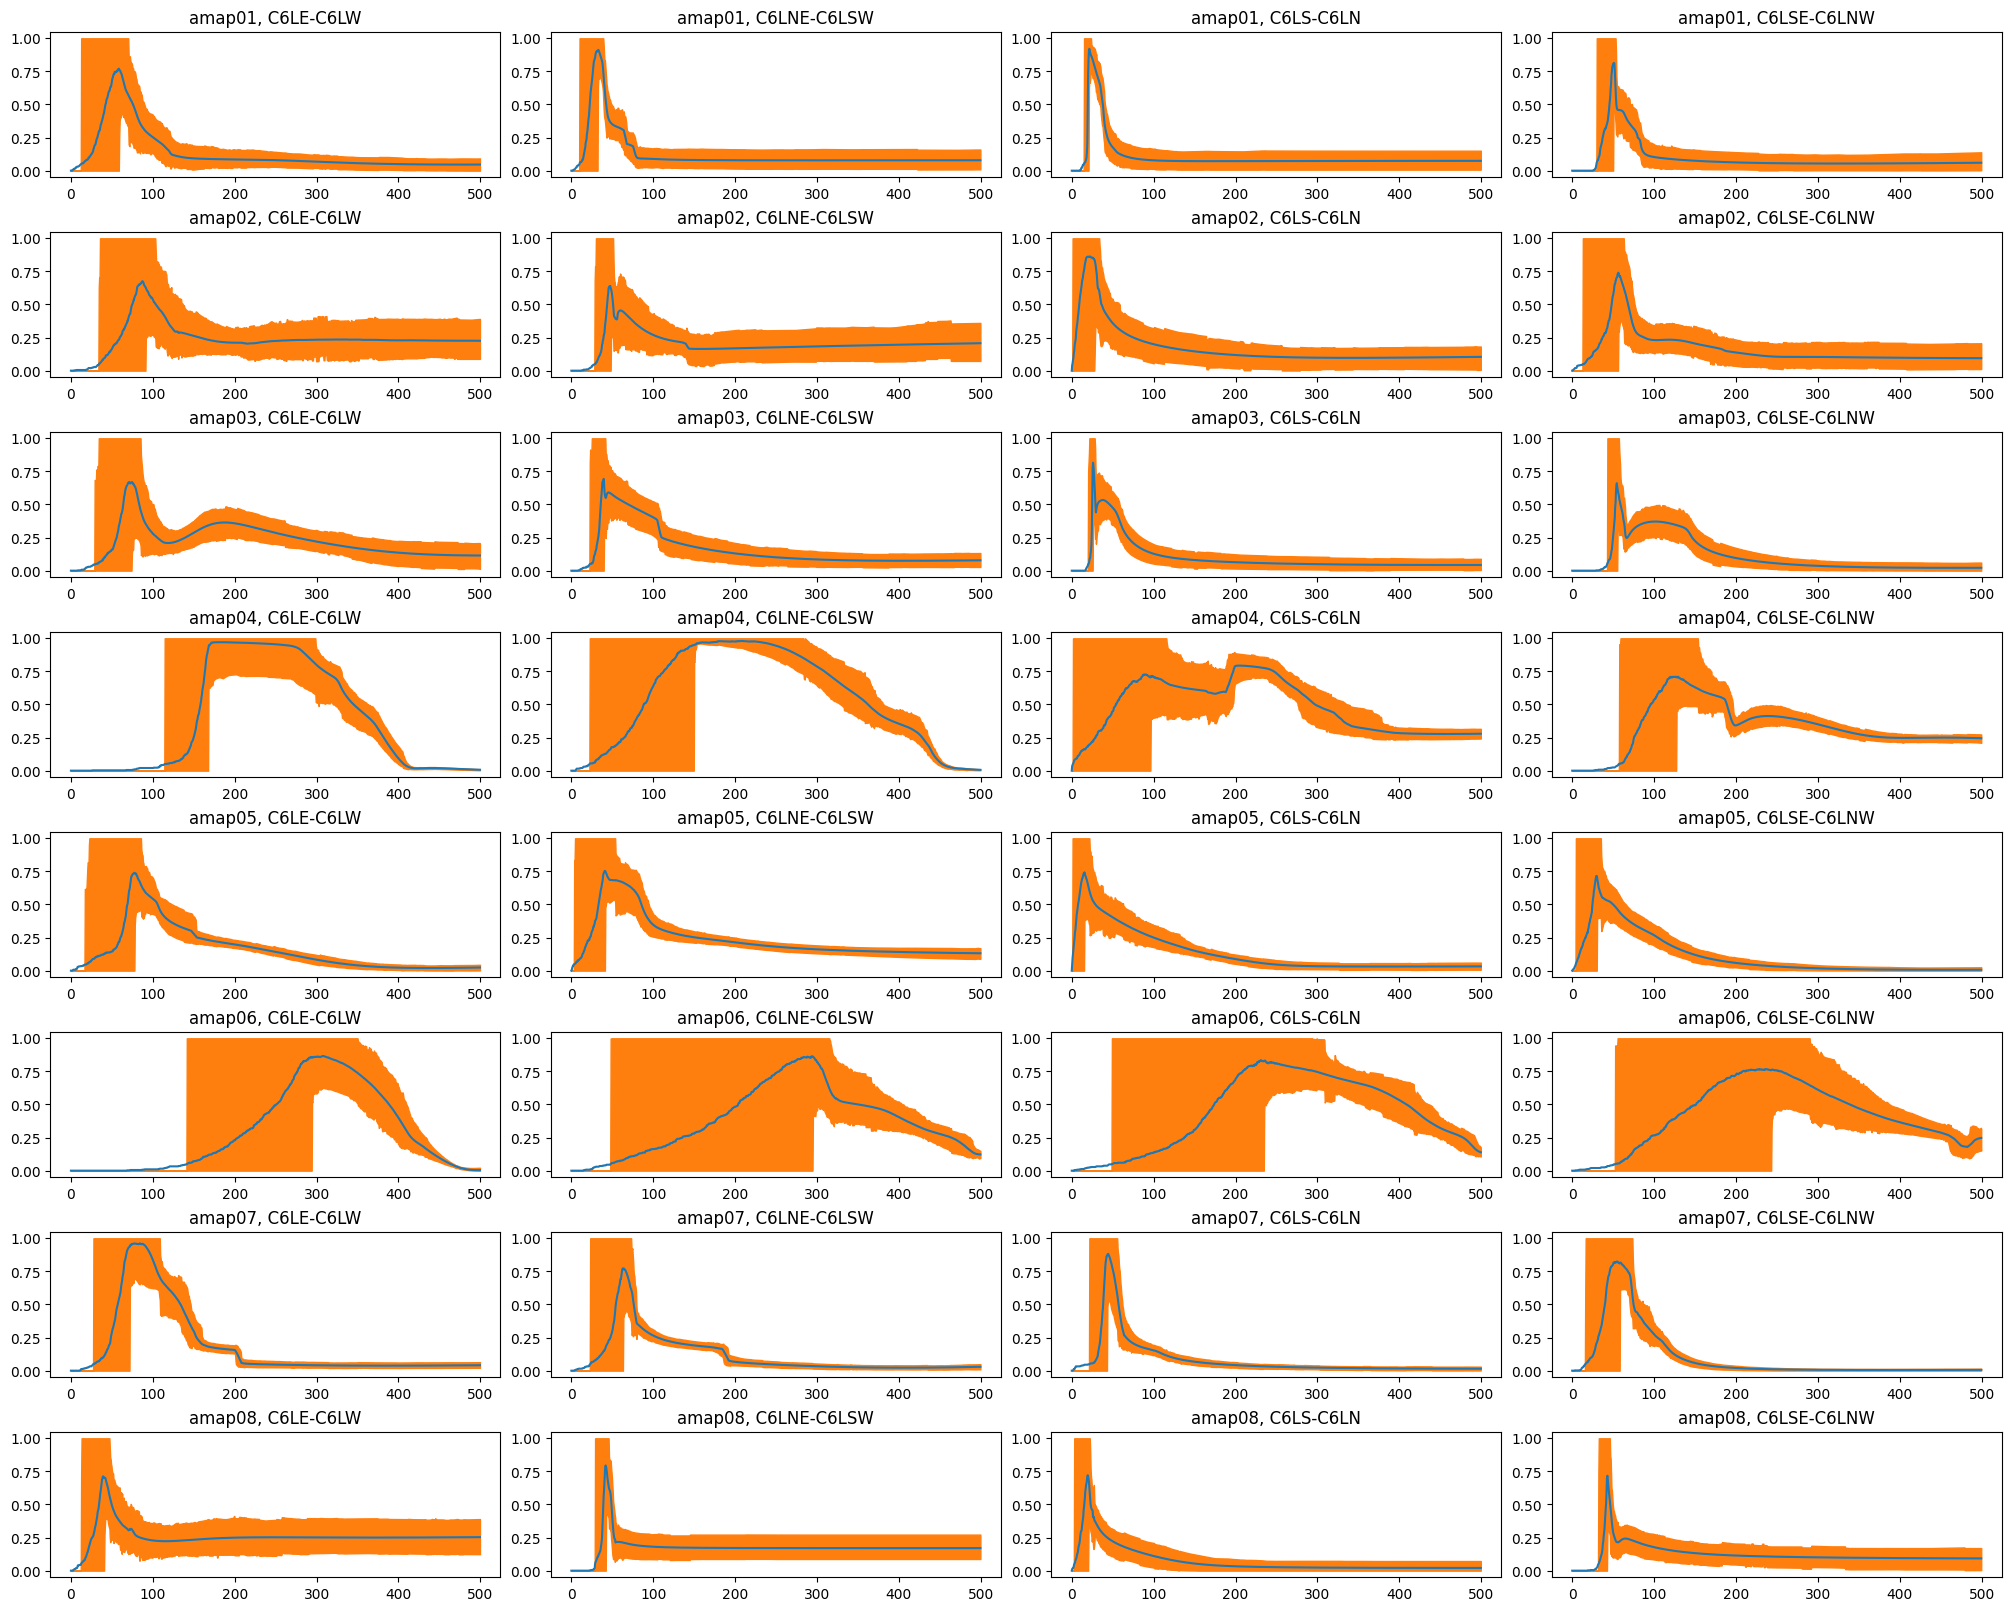

In [10]:
nrows, ncols = len(subjects), (~(entropy_mean.mask)[0, :, 0]).sum()
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, constrained_layout=True, squeeze=False, figsize=(ncols * 5, nrows * 2)
)

for subject_ind, subject in enumerate(subjects):
    j = 0
    for cpos_ind, cpos in enumerate(compound_positions):
        if entropy_mean.mask[subject_ind, cpos_ind, 0]:
            continue

        ax = axes[subject_ind, j]
        samples = entropy[subject_ind, cpos_ind, :, :]
        samples_mean = samples.mean(axis=0)
        samples_hdi = hpdi(samples, 0.95, axis=0)

        sns.lineplot(x=x, y=samples_mean, ax=ax)
        ax.fill_between(x, samples_hdi[0, :], samples_hdi[1, :], color="C1")
        ax.set_title(f"{subject}, {cpos}")
        j += 1

In [11]:
area_list = []
for subject_ind, subject in enumerate(subjects):
    j = 0
    for cpos_ind, cpos in enumerate(compound_positions):
        if entropy_mean.mask[subject_ind, cpos_ind, 0]:
            continue
        sample_integrals = entropy[subject_ind, cpos_ind, :, :]
        sample_integrals_mean = sample_integrals.mean(axis=0)
        area = np.trapz(sample_integrals_mean, x)
        area_list.append((subject, cpos, area))
        

In [12]:
area_list

[('amap01', 'C6LE-C6LW', 66.07016726605555),
 ('amap01', 'C6LNE-C6LSW', 62.07948115449304),
 ('amap01', 'C6LS-C6LN', 52.080138609027095),
 ('amap01', 'C6LSE-C6LNW', 47.2921164575271),
 ('amap02', 'C6LE-C6LW', 121.86196250064748),
 ('amap02', 'C6LNE-C6LSW', 101.49142426639786),
 ('amap02', 'C6LS-C6LN', 86.41358939331717),
 ('amap02', 'C6LSE-C6LNW', 79.88049834054745),
 ('amap03', 'C6LE-C6LW', 111.66900005099518),
 ('amap03', 'C6LNE-C6LSW', 80.42666486767668),
 ('amap03', 'C6LS-C6LN', 49.362595446398416),
 ('amap03', 'C6LSE-C6LNW', 54.321316601716994),
 ('amap04', 'C6LE-C6LW', 189.01436377235555),
 ('amap04', 'C6LNE-C6LSW', 272.9772754996543),
 ('amap04', 'C6LS-C6LN', 239.721210716452),
 ('amap04', 'C6LSE-C6LNW', 164.16204991952043),
 ('amap05', 'C6LE-C6LW', 79.34019516809629),
 ('amap05', 'C6LNE-C6LSW', 118.99697757827767),
 ('amap05', 'C6LS-C6LN', 67.71604743058077),
 ('amap05', 'C6LSE-C6LNW', 55.977781240642),
 ('amap06', 'C6LE-C6LW', 145.0454124030172),
 ('amap06', 'C6LNE-C6LSW', 187

In [13]:
filt_positions = list(set((a[1] for a in area_list)))

In [14]:
filt_positions

['C6LE-C6LW', 'C6LS-C6LN', 'C6LNE-C6LSW', 'C6LSE-C6LNW']

In [15]:
pvalues = []
means = []
lab = []
labels = []

for pos_ind_one, p_one in enumerate(filt_positions):    
    for pos_ind_two, p_two in enumerate(filt_positions):         
        if pos_ind_one == pos_ind_two:
            pvalues.append((0))
            lab.append(p_one)
            means.append(0)
            labels.append(p_one)
            continue
        group_one = np.array(list(a[2] for a in area_list if a[1] == p_one))
        group_two = np.array(list(a[2] for a in area_list if a[1] == p_two))
        ttest = stats.ttest_rel(group_one, group_two, alternative='two-sided')
        pvalues.append(ttest.pvalue)
        ci = ttest.confidence_interval(.95)
        # pvalues.append((p_one, p_two, f"{stats.ttest_rel(group_one, group_two, alternative='two-sided')[1]}"))
        t = group_one - group_two
        means.append(t.mean())
        lab.append(f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})\n{ttest.pvalue:.3f}")

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(4,4)

means = np.array(means)
means = means.reshape(4,4)

lab = np.array(lab)
lab = lab.reshape(4,4)
# unique_pvalues = set(tuple(sorted(t)) for t in pvalues)


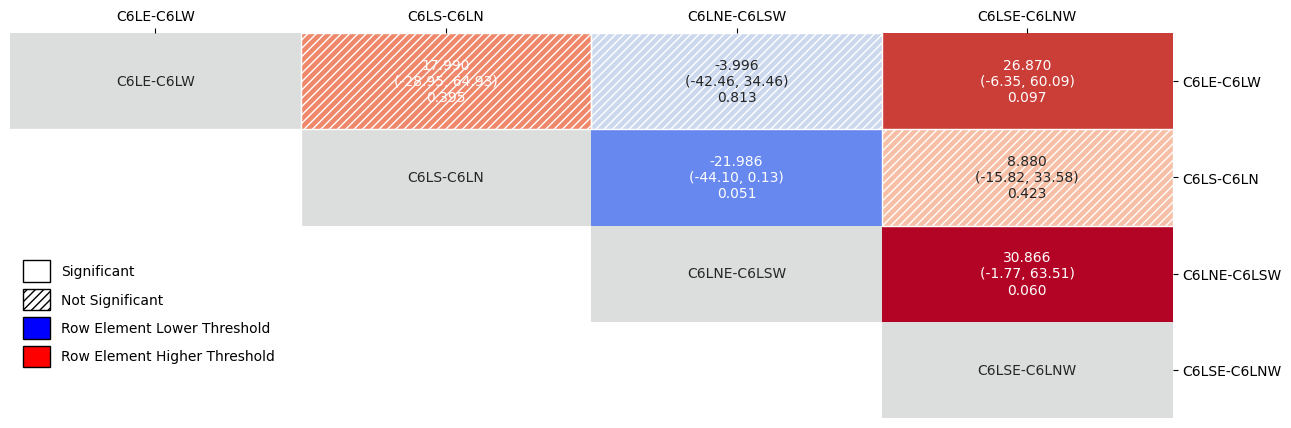

In [16]:
mask = np.tril(np.ones_like(means), k=-1)
# mask = np.tril(np.ones_like(mask), k=-1)
plt.figure(figsize=(15, 5))
ax =sns.heatmap(means, xticklabels= labels, annot = lab, yticklabels= labels, mask = mask, fmt = "", cbar = False,center = 0, cmap = "coolwarm")

hatch_mask = pvalues > 0.1
handles = []

for i in range (pvalues.shape[0]):
  for j in range(pvalues.shape[1]):
      if hatch_mask[i, j]:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
          handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
plt.show()


In [43]:
y_func = y[:, :, config, ...]
y_max_func = ma.max(y_func, axis=(1, -1), keepdims=True)
y_norm_func = ma.where(y_func, y_func / y_max_func, 0.)
y_norm_func.shape
p_func = ma.sum(y_norm_func, axis=-2, keepdims=True)
p_func = ma.where(y_norm_func, y_norm_func / p_func, 0.)
ma.any(p_func, axis=-2, keepdims=True).shape
plogp_func = ma.where(p_func, p_func * ma.log(p_func), 0)
plogp_func.shape
entropy_func = ma.where(
        ma.any(p_func, axis=-2, keepdims=True),
        (
            1
            + (ma.sum(plogp_func, axis=-2, keepdims=True) / np.log(plogp_func.shape[-2]))
        ),
        0.
        )

entropy_func = entropy_func[..., 0, :]
entropy_mean_func = ma.mean(entropy_func, axis=-2)
entropy_mean_func.shape


(8, 1000)

In [48]:
y.shape

(8, 21, 400, 6, 1000)

In [47]:
y_func.shape

(8, 21, 6, 1000)

# AUC Entropy Heatmap Function

In [50]:
def auc_heatmap_selectivity(conf, musc):
    
    config = conf
    muscle_ind = musc
    
    global y
    global subjects
    global compound_positions

    y_func = y[:, :, config, ...] # subjects, positions, muscles, samples
    y_func = y_func[..., muscle_ind, :] # subjects, positions, samples

    y_max_func = ma.max(y_func, axis=(1, -1), keepdims=True) # subjects, 1, muscles, 1

    y_norm_func = ma.where(y_func, y_func / y_max_func, 0.) # subjects, positions, muscle, samples

    p_func = ma.sum(y_norm_func, axis=-2, keepdims=True)
    p_func = ma.where(y_norm_func, y_norm_func / p_func, 0.) # subjects, positions, muscle, samples

    ma.any(p_func, axis=-2, keepdims=True).shape # subjects, positions, 1, samples
    plogp_func = ma.where(p_func, p_func * ma.log(p_func), 0)
    
    entropy_func = ma.where(
        ma.any(p_func, axis=-2, keepdims=True),
        (
            1
            + (ma.sum(plogp_func, axis=-2, keepdims=True) / np.log(plogp_func.shape[-2]))
        ),
        0.
        )
    entropy_func = entropy_func[..., 0, :] # subjects, positions, samples
    entropy_mean_func = ma.mean(entropy_func, axis=-2)

    area_list_func = []
    for subject_ind, subject in enumerate(subjects):
        j = 0
        for cpos_ind, cpos in enumerate(compound_positions):
            if entropy_mean_func.mask[subject_ind, cpos_ind, 0]:
                continue
            sample_integrals = entropy_func[subject_ind, cpos_ind, :, :]
            sample_integrals_mean = sample_integrals.mean(axis=0)
            area = np.trapz(sample_integrals_mean, x)
            area_list_func.append((subject, cpos, area))
            
    filt_positions_func = list(set((a[1] for a in area_list_func)))
    pvalues_func = []
    means_func = []
    lab_func = []
    labels_func = []
    mean_save = []

    for pos_ind_one, p_one in enumerate(filt_positions_func):    
        for pos_ind_two, p_two in enumerate(filt_positions_func):    
            group_one = np.array(list(a[2] for a in area_list_func if a[1] == p_one))
            group_two = np.array(list(a[2] for a in area_list_func if a[1] == p_two))  
               
            if pos_ind_one == pos_ind_two:
                pvalues_func.append((0))
                lab_func.append(p_one)
                means_func.append(0)
                labels_func.append(p_one)
                mean_save.append((p_one, group_one.mean()))
                continue

            ttest = stats.ttest_rel(group_one, group_two, alternative='two-sided')
            pvalues_func.append(ttest.pvalue)
            ci = ttest.confidence_interval(.95)
            # pvalues.append((p_one, p_two, f"{stats.ttest_rel(group_one, group_two, alternative='two-sided')[1]}"))
            t = group_one - group_two
            means_func.append(t.mean())
            lab_func.append(f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})\n{ttest.pvalue:.3f}")

    pvalues_func = np.array(pvalues_func)
    pvalues_func = pvalues_func.reshape(len(labels_func),len(labels_func))

    means_func = np.array(means_func)
    means_func = means_func.reshape(len(labels_func),len(labels_func))

    lab_func = np.array(lab_func)
    lab_func = lab_func.reshape(len(labels_func),len(labels_func))
    # unique_pvalues = set(tuple(sorted(t)) for t in pvalues)
    
    
    
    #PLOT
    mask = np.tril(np.ones_like(means_func), k=-1)
    # mask = np.tril(np.ones_like(mask), k=-1)
    plt.figure(figsize=(15, 8))
    ax =sns.heatmap(means_func, xticklabels= labels_func, annot = lab_func, yticklabels= labels_func, mask = mask, fmt = "", cbar = False,center = 0, cmap = "coolwarm")

    hatch_mask = pvalues_func > 0.1
    handles = []

    for i in range (pvalues_func.shape[0]):
        for j in range(pvalues_func.shape[1]):
            if hatch_mask[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='', label="Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='////', label="Not Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                        hatch='', label="Row Element Lower AUC"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                        hatch='', label="Row Element Higher AUC"))
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
            handlelength=2, handleheight=2, frameon=False)
    ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

    ax.yaxis.tick_right()
    plt.show()
    return mean_save

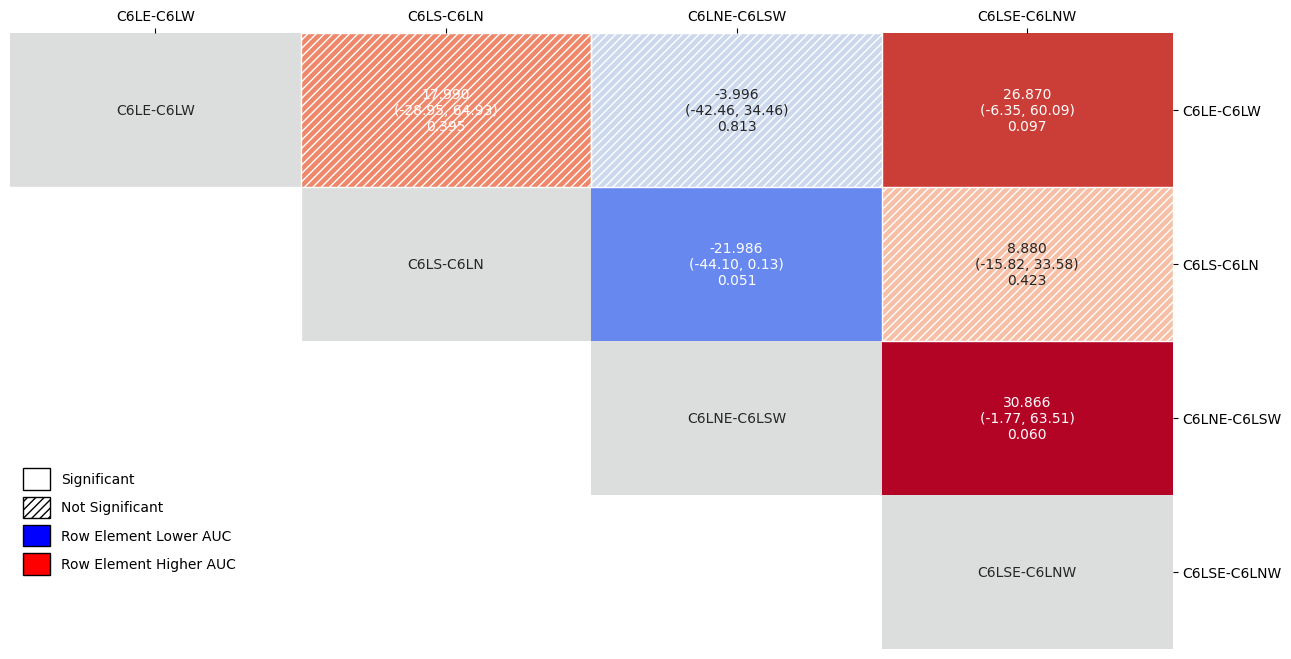

In [51]:
save_means = auc_heatmap_selectivity(2, [0,1,2,3,4,5])

In [52]:
save_means

[('C6LE-C6LW', 116.93164906622125),
 ('C6LS-C6LN', 98.94204487747031),
 ('C6LNE-C6LSW', 120.9279643965813),
 ('C6LSE-C6LNW', 90.06174500455343)]

In [53]:
with open("means.pkl", "wb") as f:
    pickle.dump(save_means, f)

# Plot Recruitment curves

In [ ]:
def render_rc(df, destination_path):
    model.render_recruitment_curves(
        df=df,
        encoder_dict=encoder_dict,
        posterior_samples=posterior_samples,
        prediction_df=prediction_df,
        posterior_predictive=posterior_predictive,
        destination_path=destination_path
    )


In [ ]:
diam = [cpos for cpos in compound_positions if cpos.split("-")[1] != "C6LC" and cpos.split("-")[0]]
diam_encoded = encoder_dict[model.features[1]].transform(diam)

ind = df[model.features[1]].isin(diam_encoded)
temp_df = df[ind].reset_index(drop=True).copy()

key = "diameters"
destination_path = f"/home/andres/repos/rat-mapping-paper/reports/L_CIRC/{key}.pdf"

render_rc(df=temp_df, destination_path=destination_path)


In [ ]:
model.render_recruitment_curves(
    df=df,
    encoder_dict=encoder_dict,
    posterior_samples=posterior_samples,
    prediction_df=prediction_df,
    posterior_predictive=posterior_predictive
)


In [ ]:
posterior_predictive[site.mu].shape #samples, (pulse amp, particpant, compound position)

(4000, 16800, 6)

In [ ]:
model.features

['participant', 'compound_position']

In [ ]:
subjects

['amap01',
 'amap02',
 'amap03',
 'amap04',
 'amap05',
 'amap06',
 'amap07',
 'amap08']

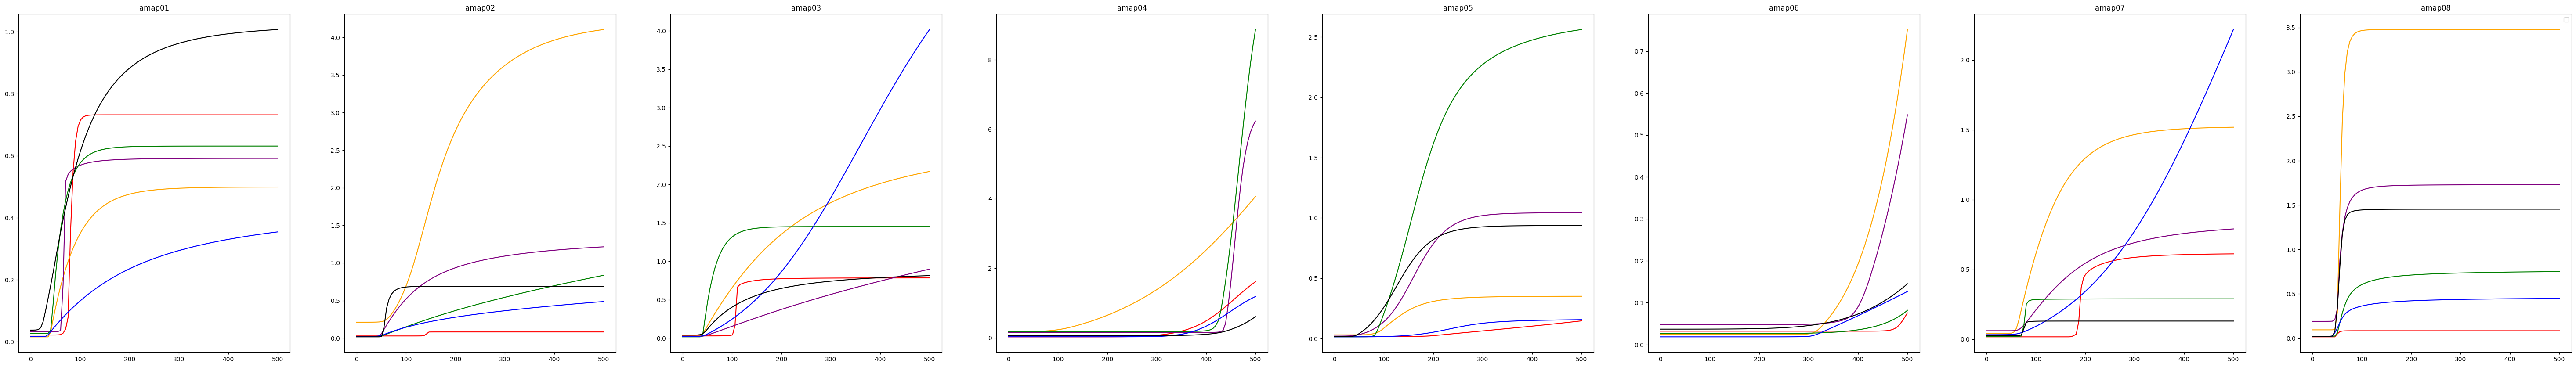

In [ ]:
cpos = "C6LNE-C6LSW"
colors = ["red", "orange", "purple", "green", "blue", "black"]
plot_labels = []
titles = []
fig, ax = plt.subplots(1,8, figsize=(75, 10))

for idx, s in enumerate(subjects):
    subject_encoded, cpos_encoded = encoder_dict[model.features[0]].transform([s]).item(), encoder_dict[model.features[1]].transform([cpos]).item()
    ind = prediction_df[model.features].apply(tuple, axis=1).isin([(subject_encoded, cpos_encoded)])
    y_temp = posterior_predictive[site.mu][:, ind, :]
    x_temp = prediction_df[ind][model.intensity].values
    ax_temp = ax[idx]
    ax_temp.set_title(s)
    
    for i in range(y_temp.shape[2]):
        sns.lineplot(x=x_temp, y=y_temp.mean(axis=0)[..., i], color= colors[i], ax = ax_temp)
        # plot_labels.append(f"{colors[i]}: {response[i]}")

plt.legend(plot_labels)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
subject, cpos = "amap01", "C6LNE-C6LSW"
subject_encoded, cpos_encoded = encoder_dict[model.features[0]].transform([subject]).item(), encoder_dict[model.features[1]].transform([cpos]).item()

subject_encoded, cpos_encoded

ind = prediction_df[model.features].apply(tuple, axis=1).isin([(subject_encoded, cpos_encoded)])
ind.sum()

y_temp = posterior_predictive[site.mu][:, ind, :]
y_temp.shape

x_temp = prediction_df[ind][model.intensity].values
x_temp.shape


(100,)

In [ ]:
def plot_muscpos_recruitmentcurves(pos):
    cpos = pos
    colors = model._get_colors(model.n_response)
    plot_labels = []
    
    
    titles = []
    fig, ax = plt.subplots(1,8, figsize=(75, 10))

    for idx, s in enumerate(subjects):
        subject_encoded, cpos_encoded = encoder_dict[model.features[0]].transform([s]).item(), encoder_dict[model.features[1]].transform([cpos]).item()
        ind = prediction_df[model.features].apply(tuple, axis=1).isin([(subject_encoded, cpos_encoded)])
        y_temp = posterior_predictive[site.mu][:, ind, :]
        x_temp = prediction_df[ind][model.intensity].values
        ax_temp = ax[idx]
        ax_temp.set_title(s)
        
        for i in range(y_temp.shape[2]):
            sns.lineplot(x=x_temp, y=y_temp.mean(axis=0)[..., i], color= colors[i], ax = ax_temp, label=f"{model.response[i]}")
            # plot_labels.append(f"{colors[i]}: {response[i]}")

    ax[0].legend()
    fig.suptitle(pos)

    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

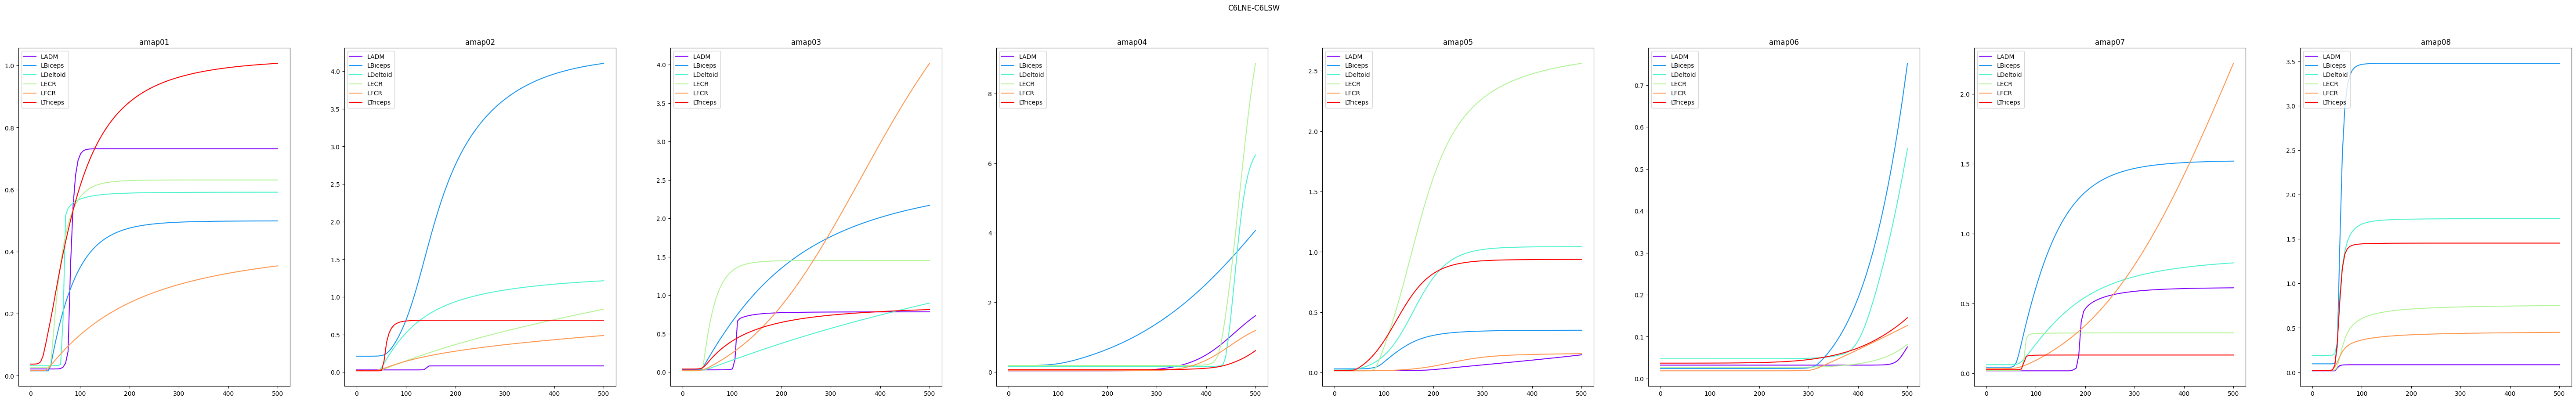

In [ ]:
plot_muscpos_recruitmentcurves("C6LNE-C6LSW")

In [ ]:
model.render_recruitment_curves()

{'H': array([[[[8.16682323e-01, 4.74662795e+00, 1.35037453e+00,
           5.42780586e-01, 2.64498407e+00, 8.34754524e-01],
          [8.15243801e-01, 1.84611072e+01, 1.83077263e-01,
           3.58909350e+00, 1.38392641e+01, 5.81206424e-01],
          [6.52768201e-01, 1.55833448e+00, 4.84687713e-01,
           6.23927494e-01, 9.26359909e-01, 8.02529521e-01],
          ...,
          [5.67358263e-01, 1.31588309e+00, 6.84743761e-01,
           7.05561389e-01, 5.10434386e+00, 9.01025848e-01],
          [7.22513912e-01, 3.65766898e-01, 1.16424401e+00,
           5.53596250e-01, 2.73291174e-01, 7.21999268e-01],
          [8.08763475e-01, 1.28114617e+00, 9.39308016e-01,
           5.73364202e-01, 2.81886780e-01, 7.37617243e-01]],
 
         [[1.28055377e+01, 1.08002663e+01, 1.06957361e+01,
           2.11754183e+01, 7.58876414e+00, 7.55254084e-01],
          [1.03496639e+01, 1.98570173e+01, 1.16385126e-01,
           1.72869321e-02, 5.35485517e+00, 7.92415740e-01],
          [5.17660952e-01